# Exploring the CERL Thesaurus

This notebook first queries the CERL Thesaurus API in order to retrieve a list of persons relevant to the field of astronomy in Early Modern Europe. It then collects and stores the data of each person in RDF format. Finally, it explores some of the characteristics of the available data.

N.B. The CERL Thesaurus data are available under the terms of [Etalab's Open Licence](http://www.etalab.gouv.fr/pages/licence-ouverte-open-licence-5899923.html)


In [1]:
### Import modules
import requests
import lxml.html
from lxml import etree
import csv
import matplotlib.pyplot as plt
from pandas import DataFrame, Series, read_csv, pivot_table, pivot

##  Get the concerned persons' authority files

The query can be tested pasting the URL in a web browser or the query part in the [CERL Thesaurus search field](https://data.cerl.org/thesaurus/).

The query seeks for astronomers, astrologers and mathematicians who were active between 1450 and 1770, i.e. practically the entire temporal range of the CERL Thesaurus. 

The result produces a list of 3102 names (26 January 2021) but some of the persons are out of scope, e.g. Firmicus Maternus, Julius.


### Execute and inspect the result

In [2]:
### Doc.:  https://2.python-requests.org/en/master/
r = requests.get('https://data.cerl.org/thesaurus/_search?query=(mathé*+OR+mathe*+OR+matem*+OR+astro*)+AND+type%3Acnp+AND+year_start:>1450+AND+year_end:<1771')

r.status_code

200

In [21]:
print(r.headers['content-type'], '\n-----')
print(r.text[:90], '\n-----')
print(type(r.text), '\n-----')
print(type(r.content), '\n')

text/html;charset=UTF-8 
-----
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <meta http-equiv= 
-----
<class 'str'> 
-----
<class 'bytes'> 



### Produce the list of persons

In [15]:
# https://www.programcreek.com/python/example/59302/lxml.etree.HTMLParser
parser = etree.HTMLParser(recover=True)

# retrieve all pages using maximal possible pagination

from_pag = 0
interv = 100

id_list = []
id_count = []

while from_pag < 3200:  # Number defined according to the manual inspected query result, 3102 on 26 January 2021

    url = 'https://data.cerl.org/thesaurus/_search?query=(mathé*+OR+mathe*+OR+matem*+OR+astro*)+AND+type%3Acnp+AND+year_start:>1450+AND+year_end:<1771&size=100&from=' + str(from_pag)

    from_pag += interv 
    
    r = requests.get(url)

    et = etree.HTML(r.content, parser)

    id_count.append(len(et.xpath('//a/@href[contains(.,"rus/cnp")]')))
    
    [id_list.append(e.replace('/thesaurus/', '')) for e in et.xpath('//a/@href[contains(.,"rus/cnp")]') if e.replace('/thesaurus/', '') ] # not in id_list

In [16]:
print(len(id_list))
id_list[-10:]

3102


['cnp01355685',
 'cnp02006023',
 'cnp02180773',
 'cnp02190984',
 'cnp02202966',
 'cnp02048444',
 'cnp02199536',
 'cnp02098294',
 'cnp02044607',
 'cnp01344247']

### Store result in a CSV file

In [17]:
with open('spreadsheets/query_import_1.csv', 'w', newline='') as csvfile:
    r_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    i = 0
    r_writer.writerow(['index', 'value'])
    for l in id_list:
        r_writer.writerow([i, l])
        i += 1


### Download the .ttl files for each person in the list

This script aims at illustrating the process of retreiving the files. 

They are then imported into a triplestore and submitted to queries that produce the CSV files available in the 'spreadsheets' folder and used in the next part of the notebook. 

This workflow will be detailed at a later stage.


In [ ]:
written_files = []

### do not execute on Binder !
#STOP# for f in id_list:
    id_file = f
    try:
        r = requests.get('https://data.cerl.org/thesaurus/'+ id_file +'?format=txt&style=ttl')
        file_address = 'CERL_files/'+ id_file +'.ttl'
        with open(file_address, 'w') as f:
            f.write(r.text)  
    except BaseException:         
        written_files.append([f,False])
    else:
        written_files.append([f,True])
        


## Explore basic characteristics of this population

In this part of the notebook we inspect information available in the CERL dataset in order to prepare the following steps.

The CERL authority files RDF data was stored in a triplestored, then queried to produce the CSV available in the 'spreadsheets' folder.



### Explore the distribution of the population by year of birth

In [22]:
birth_y_grouped = read_csv('spreadsheets/birth_years_grouped.csv', sep='\t', header=0)

In [ ]:
birth_y_grouped.head()

In [23]:
lol = birth_y_grouped.values.tolist() 
lol[:3]

[[1400, 6], [1401, 1], [1428, 1]]

In [36]:
### Create a list with intervals of 20 years, corresponding approximately to one generation.
d_list = []
period = 20
d_start = 1391
i = 0
d_list = []
d_list.append(d_start)

while i < 20:
    d_start = d_start + period
    d_list.append(d_start)
    i += 1

In [37]:
print(d_list[:2])
min(d_list), max(d_list)

[1391, 1411]


(1391, 1791)

In [51]:
# Births grouped by periods of 20 years
i_list = []
for i in d_list:
    i_n = 0
    for l in lol:
        if l[0] >= i and l[0] < (i + 30):
            i_n = i_n + l[1]
    i_list.append([i, i_n]) 
print(i_list)

[[1391, 7], [1411, 4], [1431, 46], [1451, 125], [1471, 225], [1491, 268], [1511, 268], [1531, 289], [1551, 337], [1571, 469], [1591, 451], [1611, 369], [1631, 374], [1651, 386], [1671, 366], [1691, 238], [1711, 63], [1731, 3], [1751, 3], [1771, 1], [1791, 0]]


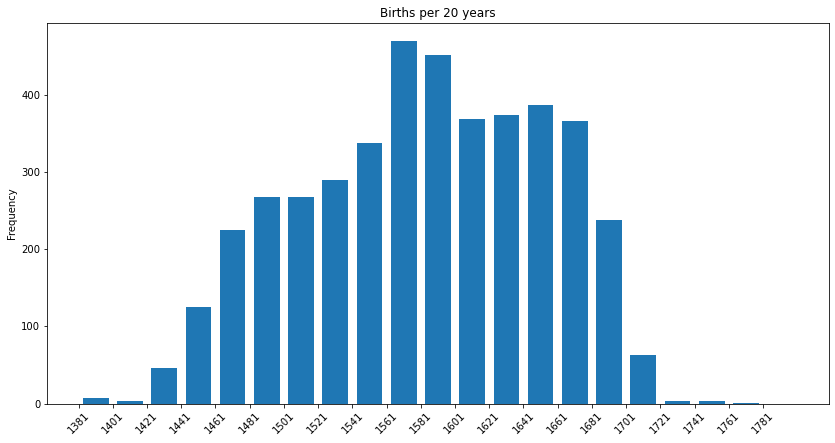

In [52]:
# Distribution by 20 years periods

generation = [e[0] for e in i_list]
eff = [e[1] for e in i_list]

p1 = plt.bar(generation, eff, width=15)

plt.xticks([i - 10 for i in d_list])
plt.ylabel('Frequency')
plt.title('Births per 20 years')
plt.gcf().set_size_inches(14, 7)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


### Inspect the activities

Analyze the main activities assigned to the actors and their distribution over time (an actor can have several activities, some have none or they are uncoded).

The coding process will be illustrated in another notebook.


In [46]:
coded_activities = read_csv('spreadsheets/coded_activities_per_person_and_year.csv', sep='\t', header=0)

In [54]:
coded_activities.head()

,subject,coded_activity,year
0,http://thesaurus.cerl.org/record/cnp02088071,Astrology,1400
1,http://thesaurus.cerl.org/record/cnp01236908,Astronomy,1400
2,http://thesaurus.cerl.org/record/cnp01324483,Astronomy,1400
3,http://thesaurus.cerl.org/record/cnp01402629,Astronomy,1400
4,http://thesaurus.cerl.org/record/cnp01402629,Mathematics,1400


### Plot the activities


The distribution of activities over time makes visible the evolution of disciplines: the 16th century is that of astrology, the 17th century that of physics. Of course in the perspective of librarians expressing the main characteristic of the activity of an actor.

Boxes are proportional to frequency of mentions. The discipline common to most persons is mathematics. 



In [55]:
from collections import Counter
count_activities = Counter(coded_activities['coded_activity'])

In [102]:
labels = count_activities.keys()
cat = tuple(count_activities.values())

cat_10 = [c/sum(cat)*2 for c in cat]

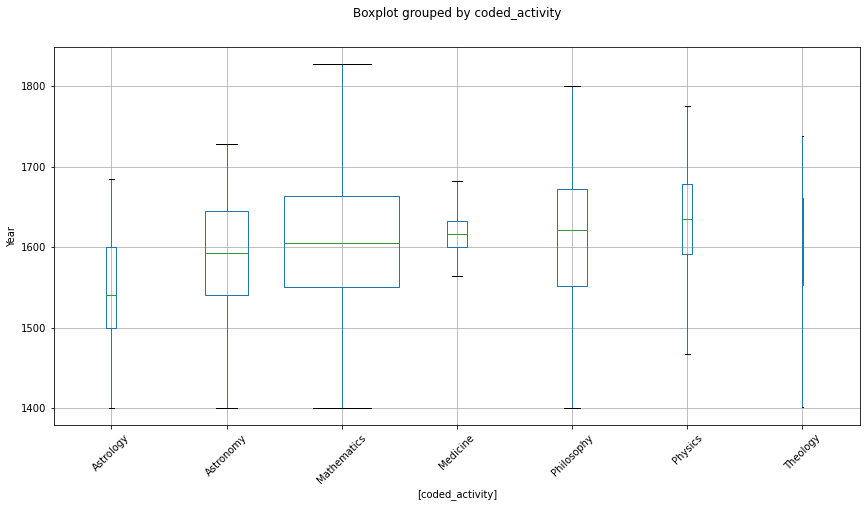

In [119]:
p = coded_activities.boxplot(by='coded_activity', 
      rot=45, figsize=(14,7), showfliers=False, widths=cat_10)
p.set_title('')

ax = p.set_ylabel("Year")

### Number of links to other resources

Most persons in CERL (75%) are related to one to four other resources. A few have more then 10, not necessarily the then best known people but those whose books are kept in several national libraries. An inspection of individual cases is needed. 


In [ ]:
number_l = read_csv('spreadsheets/number_URI_links_per_person.csv', sep='\t', header=0)
number_l.head()

In [123]:
stats_numeric = number_l.describe().round(2)
print(stats_numeric)

           eff
count  3054.00
mean      3.00
std       2.25
min       0.00
25%       1.00
50%       3.00
75%       4.00
max      19.00


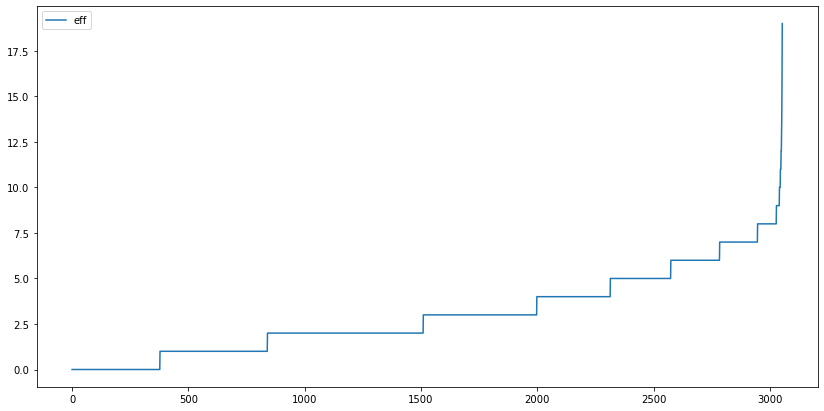

In [198]:
pl = number_l.plot(figsize=(14,7))

### Frequency of references by authority file system

In [180]:
uri_freq= read_csv('spreadsheets/URI_freq.csv', sep='\t', header=0)

In [192]:
display(uri_freq)

,freq,base_uri
0,2667,http://d-nb.info/gnd/
1,2136,http://viaf.org/viaf/
2,1550,http://www.wikidata.org/entity/
3,812,http://data.bnf.fr/ark:/12148/
4,795,http://www.idref.fr/
5,582,http://dbpedia.org/resource/
6,359,http://libris.kb.se/resource/auth/
7,249,http://isni.org/isni/
8,4,http://nektar.oszk.hu/resource/auth/
9,1,http://catalogue.bnf.fr/ark:/12148/


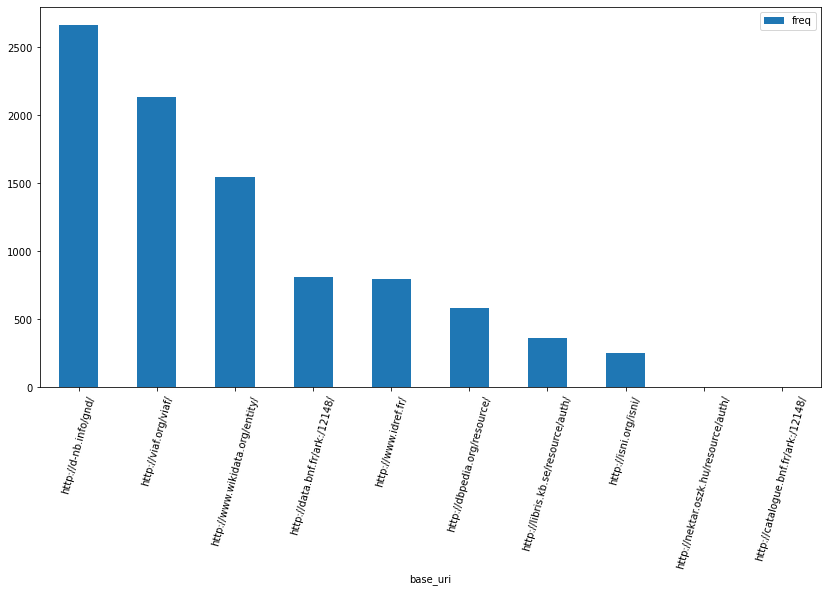

In [194]:
pt = uri_freq.plot(x='base_uri', kind='bar', rot=75, figsize=(14,7))